In [8]:
from dqn_custom_policies import CustomDQNPolicy
from models import XGEM, init_expression, simulate_and_evaluate
from snes import CKPT_DIR, HIDDEN_SIZE, get_param_list, unvectorize
from utils import get_run_data, record_video

import os
from copy import deepcopy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import gym

from stable_baselines3.dqn import DQN

import torch

from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

In [9]:
MODE = 'gem' # chose from ['gem', 'snes', 'fasm']
BIO = False
NUM_GENES = 16
NUM_NTS = 3
DEVICE = 'cuda:0'

SUFFIX = ''
if BIO: SUFFIX += '-bio'

In [ ]:
if BIO:
    # load biological genetic rules
    npz = np.load('data/genetic_rules.npz', allow_pickle=True)
    O = torch.tensor(npz['O']).bool()

    # set the correct number of genes
    NUM_GENES = O.shape[0]

if MODE == 'gem' or MODE == 'fasm':
    SHOWN_COLS = ['env_name', 'run_id', 'num_genes', 'learning_rate', 'seed', 'mean_reward', 'reward_std']

    # load data for all training runs
    df = pd.read_csv(f'data/runs{SUFFIX}.csv')

    # return the best run for each environment
    best_runs = df[df['num_genes']==NUM_GENES][SHOWN_COLS].sort_values(
        by=['mean_reward', 'reward_std', 'num_genes'],
        ascending=[False, True, True]
    ).groupby('env_name').first().reset_index()
    display(best_runs)
elif MODE == 'snes':
    SNES_SWEEP_IDS = { # bio
        'CartPole-v1': 'rrzq5qf2',
        'MountainCar-v0': '8y9l97ip',
        'LunarLander-v2': 'avzg0y32',
        'Acrobot-v1': '267vcab3'
    }
    SHOWN_COLS = ['env_name', 'run_id', 'num_genes', 'batch_size', 'test/mean_reward', 'test/reward_std', 'test/max_reward']

    # load data for all SNES sweeps' runs
    df = get_run_data('synaptogen', SNES_SWEEP_IDS)

    # return the best run for each environment
    best_runs = df[df['num_genes']==NUM_GENES][SHOWN_COLS].sort_values(
        by=['test/mean_reward', 'test/reward_std', 'num_genes'],
        ascending=[False, True, True]
    ).groupby('env_name').first().reset_index()
    display(best_runs)

In [ ]:
N_SAMPLINGS = 100
AVG_DEGREE = 1e5
N_EVAL_EPISODES = 10


# set the label for logging
if MODE == 'gem':
    type_ = 'sampled'
elif MODE == 'snes' or MODE == 'fasm':
    type_ = MODE

# simulate synaptogenesis and collect results
results = []
for env_name in best_runs['env_name'].unique():
    # initialize the environment
    env = gym.make(env_name)
    features_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    if MODE == 'gem' or MODE == 'fasm':
        # retrieve the best run 
        run = best_runs[best_runs['env_name']==env_name]
        run_id = run['run_id'].item()

        # load the trained agent
        model = DQN.load(os.path.join(f'ckpts{SUFFIX}', run_id, 'best_model.zip'), device=DEVICE)

        if MODE == 'gem': results.append({
            'env_name': env_name,
            'num_genes': NUM_GENES,
            'type': 'mean',
            'mean_reward': run['mean_reward'].item()
        })
    elif MODE == 'snes':
        # retrieve the best run 
        run = best_runs[best_runs['env_name']==env_name]
        run_id = run['run_id'].item()

        # load the optimal parameters
        x = np.load(os.path.join(CKPT_DIR + SUFFIX, f'x-{run_id}.npy'))

        # initialize the agent
        q_net = XGEM(
            layer_sizes=[features_dim, HIDDEN_SIZE, action_dim],
            num_genes=NUM_GENES,
            num_nts=NUM_NTS,
            O_temperature=.1,
            C_scale=1.,
            rules=O if BIO else None
        )
        model = DQN(
            CustomDQNPolicy,
            env,
            policy_kwargs={'q_net': q_net},
            device=DEVICE
        )
        
        # update the model parameters
        unvectorize(
            torch.tensor(x, device=DEVICE).float(),
            get_param_list(model)
        )

    if MODE == 'gem' or MODE == 'snes':
        rewards, _, best_model = simulate_and_evaluate(
            model=model,
            env=env,
            n_samplings=N_SAMPLINGS,
            n_eval_episodes=N_EVAL_EPISODES,
            avg_degree=AVG_DEGREE,
            return_best_model=True,
            pbar=True
        )
    elif MODE == 'fasm':
        rewards = []
        for seed in tqdm(range(N_SAMPLINGS)):
            # initialize gene expression in a bio-plausible way
            init_expression(
                model.q_net.q_net.Xs,
                model.q_net.q_net.Ts,
                model.q_net.q_net.Rs,
                model.q_net.q_net.biases,
                seed=seed
            )

            r, _ = simulate_and_evaluate(
                model=deepcopy(model),
                env=env,
                n_samplings=1,
                n_eval_episodes=N_EVAL_EPISODES,
                avg_degree=AVG_DEGREE
            )

            rewards += r

    # log results
    for mean_reward in rewards:
        results.append({
            'env_name': env_name,
            'num_genes': NUM_GENES,
            'type': type_,
            'mean_reward': mean_reward
        })

    print(f'{env_name}\'s max reward: {max(rewards):.2f}')

    # record a video of the best sampled network
    # record_video(env_name, best_model, name_prefix=f'{env_name}-{NUM_GENES}-sampled') # TODO: restore except for 'fasm' mode

# save results to file
df = pd.DataFrame(results)
try:
    existing_df = pd.read_csv(f'data/results{SUFFIX}.csv')
    df = pd.concat([existing_df, df], axis=0)
except:
    pass
df.to_csv(f'data/results{SUFFIX}.csv', index=False)

In [10]:
NUM_GENES = 16
REWARD_SOLVED = { # reward thresholds for considering a task solved
    'CartPole-v1': 195.0,
    'MountainCar-v0': -200, # TODO: -110.0?
    'LunarLander-v2': 200,
    'Acrobot-v1': -500
}


# load results
results = pd.read_csv(f'data/results{SUFFIX}.csv')
results = results[results['num_genes']==NUM_GENES]

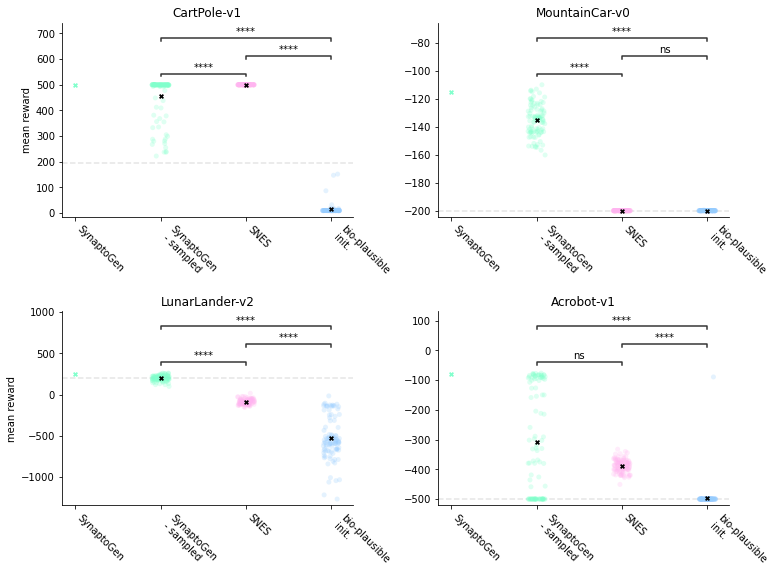

In [11]:
#--------
# Figures
#--------

NROWS = 2
NCOLS = 2
SCALE = .85

fig, axs = plt.subplots(NROWS, NCOLS, figsize=(SCALE*NCOLS*6.4, SCALE*NROWS*(4 if NROWS == 1 else 4.8)))

for i, env_name in enumerate([
    'CartPole-v1',
    'MountainCar-v0',
    'LunarLander-v2',
    'Acrobot-v1'
]):
    try: ax = axs[i//NCOLS][i%NCOLS]
    except: ax=axs[i]

    try: ax.axhline(y=REWARD_SOLVED[env_name], color='k', linestyle='--', alpha=.1)
    except: pass

    # show results
    # try: plt.axhline(y=REWARD_SOLVED[env_name], color='k', linestyle='--', alpha=.1)
    # except: pass
    sns.stripplot(ax=ax, data=results[(results['env_name']==env_name)&(results['type']=='mean')], x='type', y='mean_reward', marker='X', c='#81ffcc')
    sns.stripplot(ax=ax, data=results[(results['env_name']==env_name)&(results['type']!='mean')], x='type', y='mean_reward', order=['sampled', 'snes', 'fasm'], palette=['#81ffcc', '#ffb4f0', '#96ccfe'], alpha=.25)
    
    means = results[(results['env_name']==env_name)&(results['type']!='mean')].groupby('type')['mean_reward'].mean().reset_index()
    sns.stripplot(
        ax=ax,
        data=means, x='type', y='mean_reward', order=['sampled', 'snes', 'fasm'], palette=3*['k'],
        marker='X',
        # size=15,
        # edgecolor='k',
        # linewidth=1
    )

    annotator = Annotator(
        ax=ax,
        pairs=[('sampled', 'snes'), ('sampled', 'fasm'), ('snes', 'fasm')],
        data=results[results['env_name']==env_name],
        x='type',
        y='mean_reward',
        order=['mean', 'sampled', 'snes', 'fasm'],
        verbose=False
    )
    annotator.configure(test='Mann-Whitney', comparisons_correction='Bonferroni', text_format='star', loc='inside')
    annotator.apply_and_annotate()

    ax.set_title(env_name)
    ax.set_xticklabels(['SynaptoGen', 'SynaptoGen\n- sampled', 'SNES', 'bio-plausible\ninit.'], rotation=-45, ha='left')
    ax.set_xlabel('')
    ax.set_ylabel('mean reward' if i%NCOLS == 0 else '')
    sns.despine(ax=ax)

if NROWS > 1: plt.tight_layout()
plt.savefig(f'figs/results_{NUM_GENES}' + ('_bio' if BIO else '') + '.png', dpi=300, transparent=True)
plt.show()